
# Hackathon - Binary Classification - Solutions

In this notebook you will find the instructor's solution to the hackathon. This is one approach of many possible.
The main goal is to provide you a baseline that you can modify/expand upon and show you how to take advantage of sklearn's pipeline to simplify your workflow.

### Import the necessary libraries

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Sklearn libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc
from sklearn.base import BaseEstimator, TransformerMixin # to create classes
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

# Category encoders
from category_encoders import OneHotEncoder, TargetEncoder

#### Import the dataset

In [2]:
# You might have to change this path or the location of this file
data = pd.read_csv('data/train.csv').set_index("id")

In [3]:
data.head()

,unix_timestamp,market_sentiment,market_instability,market_volatility,trades_number,trades_size,price_buy,price_sell,price_global,orders_buy_qty,orders_sell_qty,orders_buy_qty_top20,orders_sell_qty_top20,anonymous,success
id,,,,,,,,,,,,,,,
X3HK4QZ3780BO068DDII1F38,1.627818e+12,NaN,None,0.00034,77.0,NaN,988.48333,988.59048,988.94298,40.74,8.44,305.05,21.88,category_76,1
MIYIKL1LO0C2YJWEYVJD2QSR,1.627818e+12,Very Positive,None,NaN,78.0,206.77,988.48571,988.48810,988.88298,5.50,14.95,93.53,179.09,category_85,1
YU8WZGAT0E8AHU44N52Y4O69,1.627818e+12,Very Positive,None,NaN,NaN,NaN,988.40000,988.40238,988.84869,4.20,7.39,69.51,277.49,category_22,0
T88FOCZN28J115T6AM5X9QYZ,1.627818e+12,Very Positive,None,0.00038,96.0,NaN,988.65476,988.65714,989.03988,49.18,41.96,251.58,58.59,category_133,0
N8WDQ2NL2FYAA7YOC37Q1CTO,1.627818e+12,Very Positive,Low,0.00045,137.0,338.77,989.04524,989.04762,989.57036,51.53,0.46,279.76,11.47,category_23,0


### EDA (Exploratory Dataset Analysis)

Let's start by checking the data types we are dealing with.

In [4]:
data.dtypes

unix_timestamp           float64
market_sentiment          object
market_instability        object
market_volatility        float64
trades_number            float64
trades_size              float64
price_buy                float64
price_sell               float64
price_global             float64
orders_buy_qty           float64
orders_sell_qty          float64
orders_buy_qty_top20     float64
orders_sell_qty_top20    float64
anonymous                 object
success                    int64
dtype: object

Let's check the number of unique values in our dataset.

In [5]:
data.nunique()

unix_timestamp           178204
market_sentiment              5
market_instability            4
market_volatility           157
trades_number               549
trades_size               15341
price_buy                 31277
price_sell                31283
price_global             113488
orders_buy_qty             2859
orders_sell_qty            2833
orders_buy_qty_top20      13980
orders_sell_qty_top20     13418
anonymous                   142
success                       2
dtype: int64

Let's check if we have any missing values to worry about.

In [6]:
data.isna().sum()

unix_timestamp               0
market_sentiment          9956
market_instability        3954
market_volatility        43621
trades_number            66303
trades_size              38934
price_buy                    0
price_sell                   0
price_global                 0
orders_buy_qty               0
orders_sell_qty              0
orders_buy_qty_top20         0
orders_sell_qty_top20        0
anonymous                    0
success                      0
dtype: int64

There are a lot of missing values here. We will have to find a way to deal with them...

What about correlation?

In [7]:
data.corr()[data.corr().abs()>0.7]

,unix_timestamp,market_volatility,trades_number,trades_size,price_buy,price_sell,price_global,orders_buy_qty,orders_sell_qty,orders_buy_qty_top20,orders_sell_qty_top20,success
unix_timestamp,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
market_volatility,NaN,1.000000,0.781243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trades_number,NaN,0.781243,1.000000,0.884136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trades_size,NaN,NaN,0.884136,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_buy,NaN,NaN,NaN,NaN,1.000000,0.999996,0.999967,NaN,NaN,NaN,NaN,NaN
price_sell,NaN,NaN,NaN,NaN,0.999996,1.000000,0.999967,NaN,NaN,NaN,NaN,NaN
price_global,NaN,NaN,NaN,NaN,0.999967,0.999967,1.000000,NaN,NaN,NaN,NaN,NaN
orders_buy_qty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
orders_sell_qty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
orders_buy_qty_top20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


Let's also check if are dealing with an imbalanced dataset.

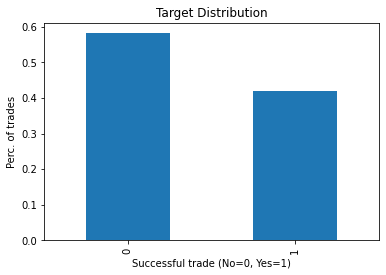

In [8]:
# Checking if the dataset is imbalanced 
data["success"].value_counts(normalize=True).plot(kind="bar")
plt.title('Target Distribution')
plt.xlabel("Successful trade (No=0, Yes=1)")
plt.ylabel("Perc. of trades");

### Feature Engineering

In [9]:
class Spread(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["spread"] = abs(data["price_buy"]/ data["price_sell"]-1)
        return X

In [10]:
class BuySellTop1Relevance(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        X["buy_sell_top1_relevance"] = (data['orders_buy_qty'] + data['orders_sell_qty']) / \
                                          (data['orders_buy_qty_top20'] + data['orders_sell_qty_top20'])
        return X

### Useful Classes

In [11]:
class Save(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X=None, y=None, **fit_params):
        return self
    def transform(self, data):
        X = data.copy()
        pd.DataFrame(X).to_csv("pipeline_spy.csv")
        return X

### Creating the Model 

Preparing the dataset for the split (don't forget to sort)

In [12]:
data = data.sort_values(by="unix_timestamp")
X = data.drop(columns=['success'])
y = data['success']

Splitting the dataset between test and train

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=False) # be careful here. By default the dataset is shuffled

Creating the pipeline

In [14]:
# Columns to use
cat_cols = ["anonymous", "market_instability"]
num_cols = ["trades_size", "market_volatility"]
feat_engineering_cols = ["spread", "buy_sell_top1_relevance"]

# Pipeline
num_transformer = Pipeline(steps=[
    ('fillna', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
cat_transformer = Pipeline(steps=[
    ("cat_encoder", TargetEncoder(cols=cat_cols))
])
preprocessor = ColumnTransformer(
    transformers=[
    ('num', num_transformer, num_cols + feat_engineering_cols),
    ('cat', cat_transformer, cat_cols),
    ])

pipeline = Pipeline([("feat_engineering_1", Spread()),
                     ("feat_engineering_2", BuySellTop1Relevance()),
                     ("preprocessor", preprocessor),
                     ('model', LogisticRegression(random_state=42))])

Train the model and generate the predictions

In [15]:
pipeline.fit(X_train, y_train)

/home/wramos/.local/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('feat_engineering_1', Spread()),
                ('feat_engineering_2', BuySellTop1Relevance()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fillna',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['trades_size',
                                                   'market_volatility',
                                                   'spread',
                                                   'buy_sell_top1_relevance']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                    

In [16]:
y_scores = pipeline.predict_proba(X_test)[:,1]

Score: 0.716


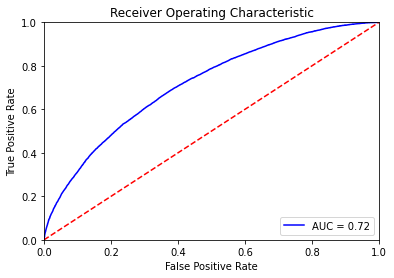

In [17]:
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
print("Score: "+ str(round(roc_auc,3)))
plt.show()

#### Check final score using the test set

Load the test set

In [18]:
test = pd.read_csv('data/test.csv').set_index("id")

Use the pipeline to get predictions (very simple!)

In [19]:
y_scores_final = pipeline.predict_proba(test)[:,1]

Prepare the submissions file

In [20]:
submission = pd.Series(y_scores_final,index=test.index, name='id')
submission.to_csv("submission.csv")

This should get you a 0.724!